# Example using audio from Fender guitar dataset: 
In this notebook all model paremeters, i.e:  noise variance, lengthscale and variance of activation, all frequencies, variances and lenghscale of component, and variational distributions are learned simultaneously by maximazing the ELBO.

In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False)

In [2]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift, fftshift
import soundfile

In [3]:
#np.random.seed(29)
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

### Load training data
In this case we have three recordings of isolated sound events.

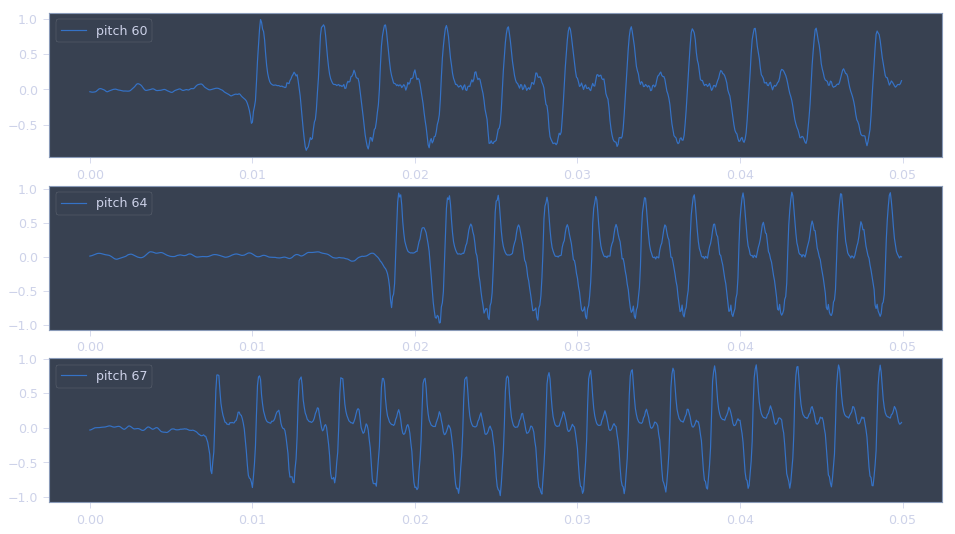

In [4]:
plist = np.asarray(['60', '64', '67'])
N, Np = 800, plist.size  # number of frames, pitches
ytrain = np.zeros((N, Np)) # number of frams by number of pitches
plt.figure(figsize=(16, 3*3))
for i in range(Np):  # load training data
    filename = '../../../../datasets/fender/train/m_' + plist[i] + '.wav'
    ytrain[:,i], fs = soundfile.read(filename, start=800, frames=N) 
    xtrain = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)
    plt.subplot(3,1,i+1)
    plt.plot(xtrain, ytrain[:,i])
    plt.legend(['pitch ' + plist[i]])

## Initialize sigmoid model

In [8]:
ws, dec = N//1, 20  # samples per window, decimation factor
Nh = 15  # number of frequency harmonics for the component process

init_model = True
if init_model:  # init model (build graph only once)
    kc = gpitch.kernels.MaternSpecMix(Nh)
    ka = gpflow.kernels.Matern32(1)
    dec, ws = 160, N  # maxiter, decimation factor, window size in samples
    model = gpitch.modpdet.ModPDet(x=xtrain, y=ytrain[:,0].reshape(-1, 1), ker_com=kc, 
                                   ker_act=ka, ws=ws, dec=dec)
    model.model.kern1.fixed = True
    model.model.kern1.lengthscales.fixed = False
    model.model.kern1.lengthscales.transform = gpflow.transforms.Logistic(0., 0.1)
    model.model.kern1.frequency_1.fixed = False
    model.model.kern1.frequency_2.fixed = False
    model.model.kern1.frequency_3.fixed = False
    model.model.kern1.frequency_4.fixed = False
    model.model.kern1.frequency_5.fixed = False
    model.model.kern1.frequency_6.fixed = False
    model.model.kern1.frequency_7.fixed = False
    model.model.kern1.frequency_8.fixed = False
    model.model.kern1.frequency_9.fixed = False
    model.model.kern1.frequency_10.fixed = False
    model.model.kern1.frequency_11.fixed = False
    model.model.kern1.frequency_12.fixed = False
    model.model.kern1.frequency_13.fixed = False
    model.model.kern1.frequency_14.fixed = False
    model.model.kern1.frequency_15.fixed = False
    model.model.kern2.fixed = False
    model.model.likelihood.noise_var.fixed = False

In [6]:
for i in range(len(all_pitches)):
    aux = list(all_pitches)
    aux.pop(i)
    pitch_detect = np.asarray([all_pitches[i]])  # pitch to detect
    pitch_others = np.asarray(aux)  # other pitches in the mixture

    # fnl: filename list, td: training data, pd: pitch to detect, op: others pitches
    fnl_dp, td_dp, params_dp = gpitch.amtgp.load_pitch_params_data(pitch_detect, data_loc=data_location,
                                                                   params_loc=params_location)
    fnl_op, td_op, params_op = gpitch.amtgp.load_pitch_params_data(pitch_others, data_loc=data_location,
                                                                   params_loc=params_location)
    s_act_op = np.zeros(pitch_others.size)
    l_act_op = np.zeros(pitch_others.size)
    s_com_op = [None]*pitch_others.size
    l_com_op = [None]*pitch_others.size
    f_com_op = [None]*pitch_others.size

    for j in range(pitch_others.size):  # take mean for lengthscale and variance of activations
        s_act_op[j] = params_op[j]['s_act']
        l_act_op[j] = params_op[j]['l_act']
        s_com_op[j] = params_op[j]['s_com']
        l_com_op[j] = params_op[j]['l_com']
        f_com_op[j] = params_op[j]['f_com']

    params = {'l_act1' : params_dp[0]['l_act'],
              's_act1' : params_dp[0]['s_act'],
              'l_act2' : params_dp[0]['l_act'],
              's_act2' : params_dp[0]['s_act'],
              'l_com1' : params_dp[0]['l_com'],
              's_com1' : params_dp[0]['s_com'],
              'f_com1' : params_dp[0]['f_com'],
              'l_com2' : np.vstack(l_com_op),
              's_com2' : 0.25*np.vstack(s_com_op),
              'f_com2' : np.vstack(f_com_op)}

    model.update_params(params)  # update hyperparms to detect specific pitch
    maxiter = 25
    print('detecting pitch ' +  pitch_detect[0])
    model.optimize_windowed(disp=0, maxiter=maxiter)
    model.save_results('../../../results/files/demos/loogp/results_maps_pitch_'+ pitch_detect[0])

NameError: name 'all_pitches' is not defined